<a href="https://colab.research.google.com/github/Shivampal7405/Eye-disease-detection-model/blob/main/cataract%20detection%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.layers import Dropout
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import from tensorflow.keras.preprocessing.image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [46]:
data ='/content/drive/MyDrive/EYE'


In [47]:
pip install split-folders


In [20]:
import splitfolders
splitfolders.ratio(data, output="dataset", seed=1337, ratio=(.7, .1, .2))

Copying files: 1360 files [00:32, 41.25 files/s]


In [48]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    data,
    image_size=(256,256),
    batch_size=32
)

Found 1359 files belonging to 4 classes.


In [49]:
class_names = dataset.class_names
class_names

['GRADE 0', 'GRADE 1', 'GRADE 2', 'GRADE 3']

In [50]:
for image_batch , label_batch in dataset.take(1):
  print(image_batch[3].shape)
  print(label_batch.numpy())

(256, 256, 3)
[0 2 0 1 1 0 2 1 0 1 0 0 2 1 0 1 0 0 0 2 0 0 1 0 0 2 3 2 0 1 2 3]


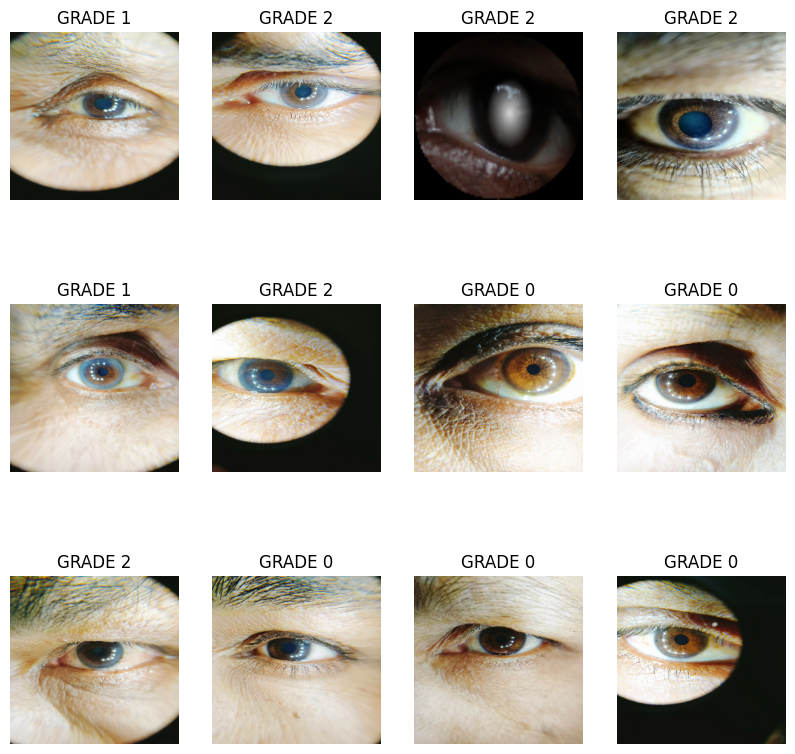

In [24]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [51]:
train_size = 0.8
len(dataset)*train_size

34.4

In [26]:
train_ds =dataset.take(20)
len(train_ds)

20

In [27]:
test_ds =dataset.skip(20)
len(test_ds)

23

In [28]:
val_ize = 0.1
len(dataset)*val_ize

4.3

In [29]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [30]:
test_ds =test_ds.skip(2)
len(test_ds)

21

In [52]:
import tensorflow as tf

def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size , seed =12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  def split_dataset(ds, train_size, val_size):
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

In [53]:
import tensorflow as tf

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    test_size = ds_size - train_size - val_size

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size) # Create val_ds
    test_ds = ds.skip(train_size + val_size) # Create test_ds

    return train_ds, val_ds, test_ds # Return all three datasets

# Assuming 'your_tf_dataset' is a TensorFlow Dataset defined somewhere earlier in the code
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset) # Call the function with the correct dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
import os
import tensorflow as tf
data_dir = '/content/drive/MyDrive/EYE'


for folder in os.listdir(data_dir):
    print(folder)

GRADE 3
GRADE 1
GRADE 2
GRADE 0


In [55]:
import tensorflow as tf
from tensorflow.keras import layers
image_height = 256
image_width = 256

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_height, image_width),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

In [42]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'

In [57]:
train_datagen =ImageDataGenerator(
    rescale =1./255,
    rotation_range = 10,
    horizontal_flip=True
)
train_generator =train_datagen.flow_from_directory(
   '/content/dataset/train',
    target_size=(256,256),
    batch_size=32,
    class_mode='sparse',
    save_to_dir='/content/drive/MyDrive/Augmentedimages'
)

Found 949 images belonging to 4 classes.


In [58]:
image_batch =32
image_size =256
batch_size =32
for image_batch, label_batch in train_generator:
    print(image_batch.shape)
    print(image_batch[0])
    break

(32, 256, 256, 3)
[[[0.53141266 0.4765107  0.4412166 ]
  [0.4901961  0.43540934 0.40011522]
  [0.49041912 0.43921572 0.40397736]
  ...
  [0.04550852 0.03766538 0.04158695]
  [0.04414828 0.03630514 0.04022671]
  [0.04313726 0.03529412 0.03921569]]

 [[0.53080577 0.47539833 0.44111526]
  [0.4964104  0.44150844 0.40621433]
  [0.4901961  0.43859136 0.40329725]
  ...
  [0.04313726 0.03529412 0.03921569]
  [0.04313726 0.03529412 0.03921569]
  [0.04302208 0.03517894 0.03910051]]

 [[0.52740526 0.4713176  0.43839476]
  [0.50389177 0.44898978 0.41369566]
  [0.4901961  0.43791124 0.40261713]
  ...
  [0.04052017 0.03267704 0.0365986 ]
  [0.03984005 0.03199692 0.03591849]
  [0.03915993 0.0314283  0.03540563]]

 ...

 [[0.04700307 0.05092464 0.05893504]
  [0.04768319 0.05160476 0.0594479 ]
  [0.04836331 0.05228488 0.06012802]
  ...
  [0.03137255 0.02352941 0.03529412]
  [0.03137255 0.02352941 0.03529412]
  [0.03018692 0.02471504 0.03529412]]

 [[0.05086521 0.05478678 0.06262992]
  [0.04928558 0.053

In [59]:
train_generator.class_indices


{'GRADE 0': 0, 'GRADE 1': 1, 'GRADE 2': 2, 'GRADE 3': 3}

In [60]:
class_names = list(train_generator.class_indices.keys())
class_names

['GRADE 0', 'GRADE 1', 'GRADE 2', 'GRADE 3']

In [61]:
validation_datagen =ImageDataGenerator(
    rescale =1./255,
    rotation_range = 10,
    horizontal_flip=True
)
validation_generator =train_datagen.flow_from_directory(
   '/content/dataset/val',
    target_size=(256,256),
    batch_size=32,
    class_mode='sparse',
)

Found 134 images belonging to 4 classes.


In [62]:
test_datagen =ImageDataGenerator(
    rescale =1./255,
    rotation_range = 10,
    horizontal_flip=True
)
test_generator =train_datagen.flow_from_directory(
   '/content/dataset/test',
    target_size=(256,256),
    batch_size=32,
    class_mode='sparse',
)

Found 276 images belonging to 4 classes.


In [63]:
train = train_generator.n
val = validation_generator.n
test = test_generator.n

In [ ]:
print(train)

In [64]:
# Iterate over the generator to get batches of data and labels
for x_batch, y_batch in train_generator:
    x_train = x_batch  # Store the data batch
    y_train = y_batch  # Store the label batch
    break  # Exit the loop after the first batch

# Similarly for validation and test data
for x_batch, y_batch in validation_generator:
    x_val = x_batch
    y_val = y_batch
    break

for x_batch, y_batch in test_generator:
    x_test = x_batch
    y_test = y_batch
    break

In [ ]:
print(x_train.shape)

In [65]:
from tensorflow.keras.applications import VGG19

vgg = VGG19(input_shape=(256, 256, 3), weights='imagenet', include_top=False)


In [66]:
for layer in vgg.layers:
    layer.trainable = False

In [67]:
x = Flatten()(vgg.output)
predection = Dense(3, activation='softmax')(x)

**VGG19**

In [68]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model

vgg = VGG19(input_shape=(256, 256, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(3, activation='softmax')(x)

# Create a new Model instance
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,122,691 (76.76 MB)

 Trainable params: 98,307 (384.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,155,460 (76.89 MB)

 Trainable params: 131,076 (512.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

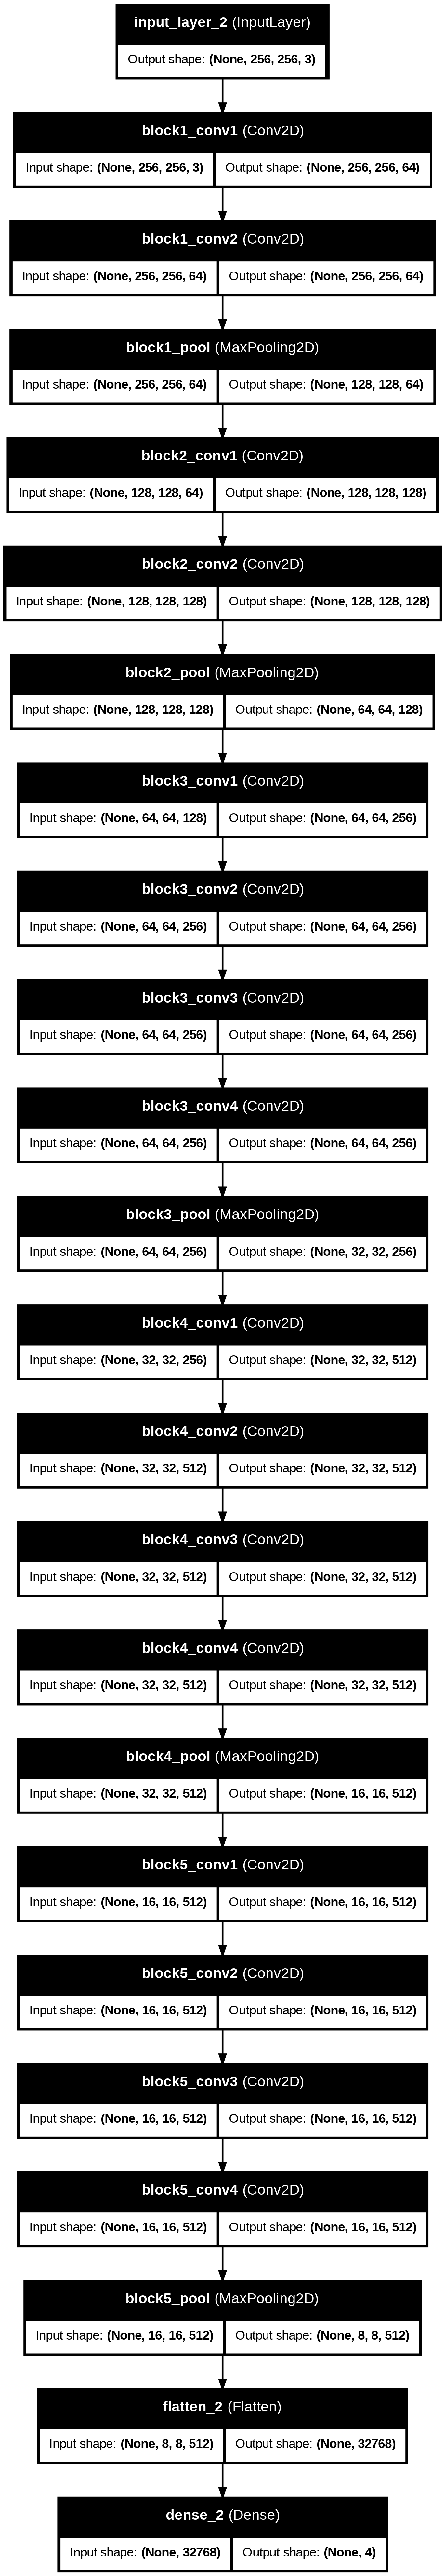

In [69]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model # Import the plot_model function

vgg = VGG19(input_shape=(256, 256, 3), weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

# Create a new Model instance
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

plot_model(model,show_shapes=True, show_layer_names=True) # Now you can use plot_model

In [70]:
early_stop =EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model

<Functional name=functional_1, built=True>

In [71]:

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [72]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming your labels are in the range [0, 3], change the number of neurons in the Dense layer to 4
prediction = Dense(4, activation='softmax')(x)

# Recreate the model with the updated Dense layer
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,155,460 (76.89 MB)

 Trainable params: 131,076 (512.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [73]:


# Compile the new model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # Compile the model again after redefining it

history = model.fit(x_train, y_train,
          epochs=15,
          validation_data=(x_val, y_val),
          callbacks=[early_stop],
          verbose=1,
          batch_size =32)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step - accuracy: 0.1875 - loss: 2.4648 - val_accuracy: 0.6875 - val_loss: 3.1174
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 89s 89s/step - accuracy: 0.7188 - loss: 2.4679 - val_accuracy: 0.6875 - val_loss: 4.2061
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 134s 134s/step - accuracy: 0.7188 - loss: 3.0372 - val_accuracy: 0.6875 - val_loss: 4.2092
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 77s 77s/step - accuracy: 0.7188 - loss: 2.5449 - val_accuracy: 0.6875 - val_loss: 3.5844
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 87s 87s/step - accuracy: 0.8125 - loss: 1.6753 - val_accuracy: 0.7188 - val_loss: 2.8580
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 82s 82s/step - accuracy: 0.8125 - loss: 0.9443 - val_accuracy: 0.6250 - val_loss: 2.3777
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 83s 83s/step - accuracy: 0.7812 - loss: 0.4421 - val_accuracy: 0.5625 - val_loss: 2.3224
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 75s 75s/step - accuracy: 0.9062 - loss: 0.4123 - val_accuracy: 0.1562 - val_loss: 3.051

In [74]:
# Assuming 'x_val' and 'y_val' are your validation data
scores = model.evaluate(x_val, y_val)
print("Scores: ", scores)

1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step - accuracy: 0.5625 - loss: 2.3224
Scores:  [2.322373390197754, 0.5625]


In [81]:
import numpy as np
from keras.preprocessing import image

# Load and preprocess the image
img_path = '/content/drive/MyDrive/EYE/GRADE 2/07bd03b5-aa58-493e-9a0d-522e494f9bfa.jpg'
img = image.load_img(img_path, target_size=(image_height, image_width))  # Replace with your image dimensions
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values

# Make the prediction
scores = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
prediction
0
GRADE 0


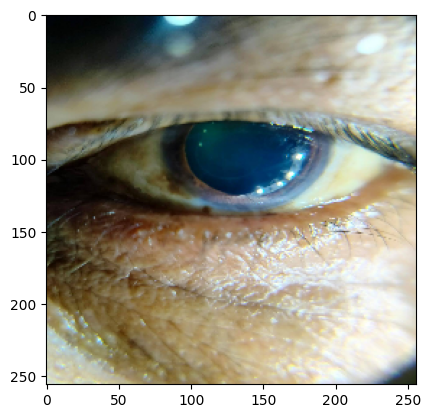

In [82]:

batch_predection = model.predict(img_array)
plt.imshow(img_array[0]) # Removed extra space before plt.imshow
print("prediction")
print(np.argmax(batch_predection[0]))
print(class_names[np.argmax(batch_predection[0])])

In [83]:
scores =model.evaluate(img_array)

ValueError: None values not supported.

In [85]:
batch = model.predict(img_array)
print(class_names[np.argmax(batch[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
GRADE 0


<function matplotlib.pyplot.show(close=None, block=None)>

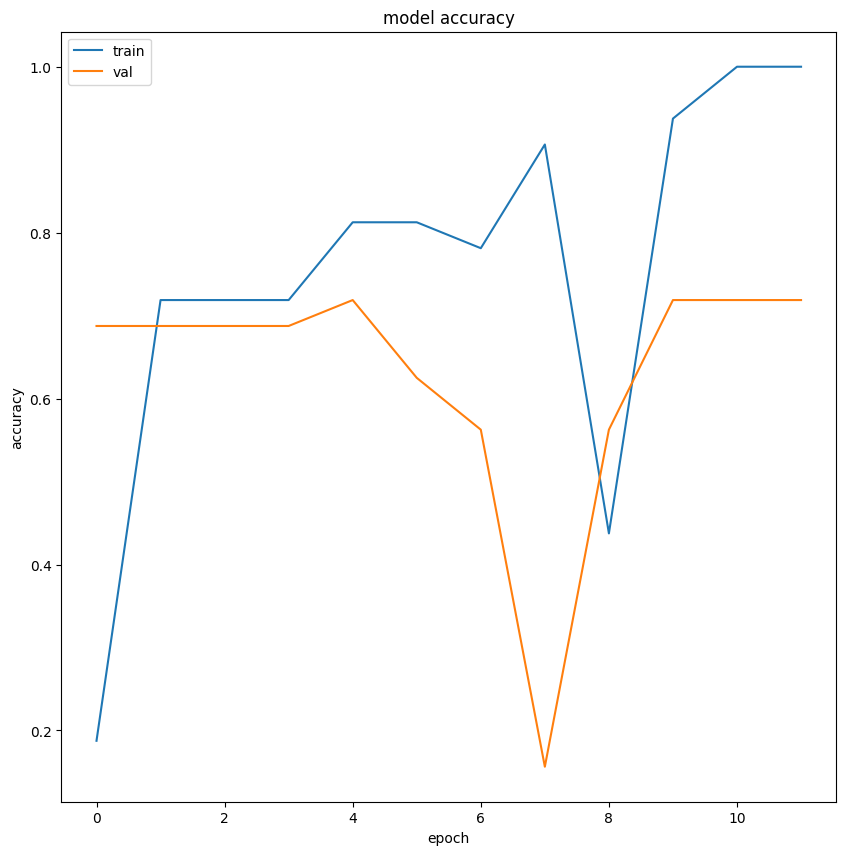

In [84]:
plt.figure(figsize=(10,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

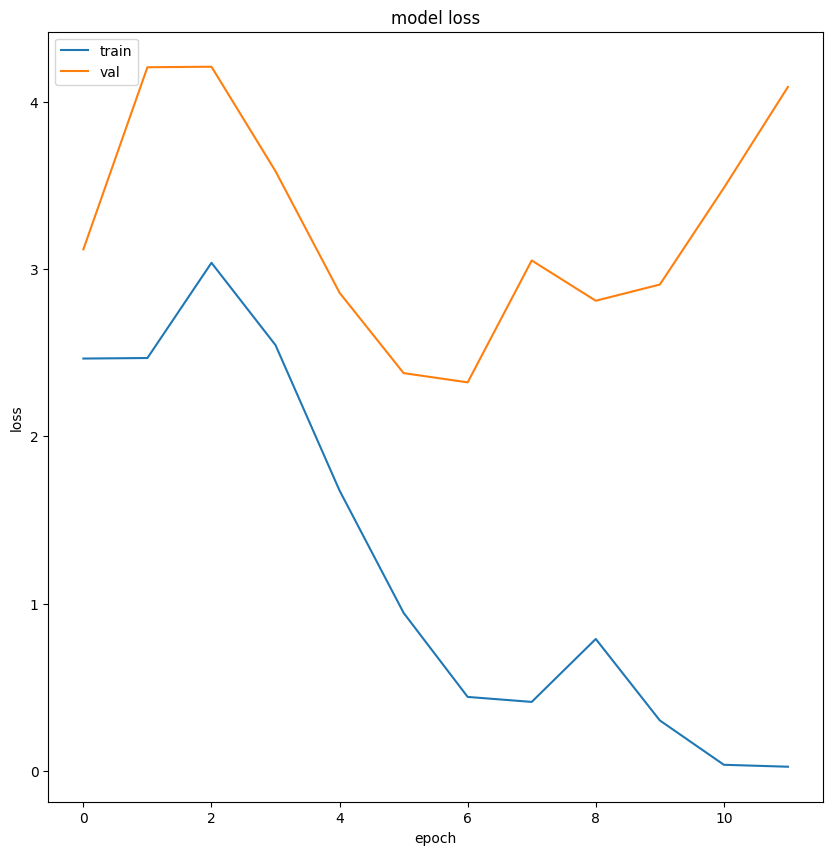

In [86]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

In [87]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6) # Removed extra spaces before this line

history = model.fit(..., callbacks=[early_stop, reduce_lr])

ValueError: Unrecognized data type: x=Ellipsis (of type <class 'ellipsis'>)

In [ ]:
from tensorflow.keras.layers import Dropout
x = Dropout(0.5)(x)  # Adjust dropout rate as needed

In [ ]:
prediction = Dense(4, activation='softmax', kernel_regularizer='l2')(x)

In [ ]:
# Unfreeze some layers in VGG19
for layer in vgg.layers[-5:]:  # Unfreeze the last 5 layers (adjust as needed)
    layer.trainable = True

# Recompile the model after making layers trainable
model.compile(optimizer=Adam(learning_rate=1e-5),  # Use a lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on your training data
datagen.fit(x_train)

# Use the generator in model.fit
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

In [ ]:
import numpy as np
from keras.preprocessing import image

# Load and preprocess the image
img_path = '/content/drive/MyDrive/EYE/GRADE 3/IMG_20240623_110041_453.jpg'
img = image.load_img(img_path, target_size=(256, 256))  # Replace with your image dimensions
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values

# Make the prediction
scores = model.predict(img_array)

scores = model.predict(img_array)
batch_predection = model.predict(img_array)
plt.imshow(img_array[0]) # Removed extra space before plt.imshow
print("prediction")
print(np.argmax(batch_predection[0]))
print(class_names[np.argmax(batch_predection[0])])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 898ms/step
prediction
0
GRADE 0


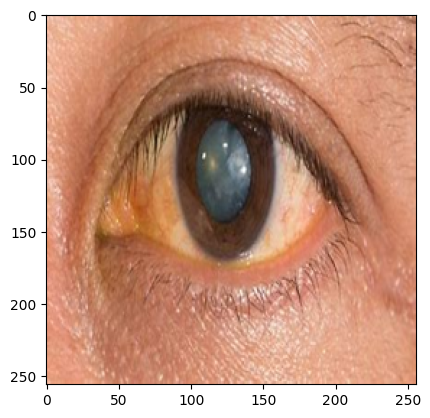

In [88]:
import numpy as np
from keras.preprocessing import image
import requests
from PIL import Image
import io

# Load and preprocess the image
img_path = 'https://th.bing.com/th/id/OIP.wtt0CHZZHoO-0RFORio0bQHaDt?w=312&h=175&c=7&r=0&o=5&dpr=1.3&pid=1.7'
response = requests.get(img_path) # Fetch image from the URL
img = Image.open(io.BytesIO(response.content)) # Open the image from the response content
img = img.resize((256, 256)) # Resize the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Normalize pixel values

# Make the prediction
scores = model.predict(img_array)

scores = model.predict(img_array)
batch_predection = model.predict(img_array)
plt.imshow(img_array[0])
print("prediction")
print(np.argmax(batch_predection[0]))
print(class_names[np.argmax(batch_predection[0])])

CNN Sequential model


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
Prediction for image 1:
Class index: 0
Class name: GRADE 0


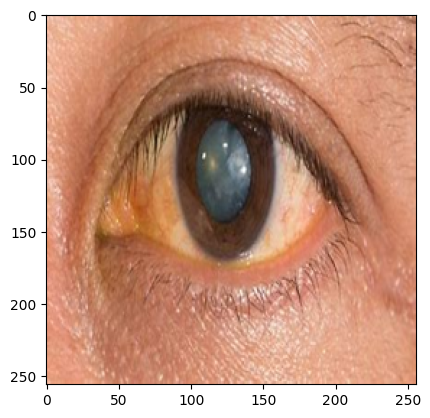

In [89]:
# Assuming 'img_array' is a NumPy array of shape (n, image_height, image_width, 3) containing n images
batch_predictions = model.predict(img_array)

# Iterate over the predictions and display results
for i in range(img_array.shape[0]):
    plt.figure()  # Create a new figure for each image
    plt.imshow(img_array[i])
    predicted_class_index = np.argmax(batch_predictions[i])
    predicted_class_name = class_names[predicted_class_index]
    print("Prediction for image {}:".format(i + 1))
    print("Class index:", predicted_class_index)
    print("Class name:", predicted_class_name)
    plt.show()

In [ ]:
pip install tensorflowjs


In [75]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/saved_model/model.h5')

In [ ]:
from tensorflow.keras.models import load_model
import os

# Mount Google Drive (if you haven't already)
from google.colab import drive
drive.mount('/content/drive')

# Construct the correct file path - check for typos!
model_path = os.path.join('/content/drive/MyDrive/saved_model', 'model.h5')

# Load your pre-trained model
model = load_model(model_path)

In [79]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/saved-model/model.js')

failed to lookup keras version from the file,
    this is likely a weight only file


In [80]:
import shutil
shutil.make_archive('model', 'zip', '/content/drive/MyDrive/saved_model/model.h5')

'/content/model.zip'